In [208]:
# ESG Scoring using Bag-of-Words Model
# Following Exercise methodology and evaluating against benchmark

import pandas as pd
import numpy as np
import os
import json
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

In [209]:
# 1. Load and Prepare ESG Data for All 15 Companies

def load_benchmark_scores():
    """Load benchmark ESG scores from benchMark.md"""
    benchmark_scores = {
        'Nike': 70, 'Apple': 70, 'Boeing': 79, 'Disney': 68, 'Eli Lilly': 64, 'FedEx': 71,
        'Johnson & Johnson': 85, 'JPMorgan Chase': 80, 'McDonald\'s': 66, 'Meta': 60,
        'Microsoft': 87, 'Netflix': 37, 'NVIDIA': 77, 'Tesla': 72, 'Google': 81
    }
    return benchmark_scores

def load_company_documents():
    """Load all ESG-related documents for each company"""
    data_path = "data"
    company_texts = {}
    
    # Company directory mapping
    company_dirs = {
        'Nike': 'nike', 'Apple': 'apple', 'Boeing': 'boeing', 'Disney': 'disney',
        'Eli Lilly': 'elililly', 'FedEx': 'fedex', 'Johnson & Johnson': 'johnsonandjohnson',
        'JPMorgan Chase': 'jpmorganchase', 'McDonald\'s': 'mcdonald', 'Meta': 'meta',
        'Microsoft': 'microsoft', 'Netflix': 'netflix', 'NVIDIA': 'nvidia',
        'Tesla': 'tesla', 'Google': 'google'
    }
    
    print("Loading company documents...")
    for company, dir_name in company_dirs.items():
        company_path = os.path.join(data_path, dir_name)
        if os.path.exists(company_path):
            all_text = ""
            file_count = 0
            
            # Load all relevant files
            for file in os.listdir(company_path):
                if file.endswith(('.md', '.txt')):
                    file_path = os.path.join(company_path, file)
                    try:
                        with open(file_path, 'r', encoding='utf-8') as f:
                            content = f.read()
                            all_text += content + " "
                            file_count += 1
                    except Exception as e:
                        print(f"Error reading {file_path}: {e}")
            
            if all_text.strip():
                company_texts[company] = all_text.strip()
                print(f"✓ {company}: {file_count} files, {len(all_text)} characters")
            else:
                print(f"✗ {company}: No text found")
        else:
            print(f"✗ {company}: Directory not found - {company_path}")
    
    return company_texts

# Load data
benchmark_scores = load_benchmark_scores()
company_texts = load_company_documents()

print(f"\nLoaded data for {len(company_texts)} companies")
print(f"Benchmark scores available for {len(benchmark_scores)} companies")

# Create dataset
data = []
for company in company_texts.keys():
    if company in benchmark_scores:
        data.append({
            'company': company,
            'text': company_texts[company],
            'esg_score': benchmark_scores[company]
        })

esg_df = pd.DataFrame(data)

Loading company documents...
✓ Nike: 5 files, 659450 characters
✓ Apple: 5 files, 497888 characters
✓ Boeing: 5 files, 479248 characters
✓ Disney: 5 files, 350162 characters
✓ Eli Lilly: 5 files, 484244 characters
✓ FedEx: 5 files, 426485 characters
✓ Johnson & Johnson: 5 files, 143977 characters
✓ JPMorgan Chase: 5 files, 524828 characters
✓ McDonald's: 5 files, 266684 characters
✓ Meta: 5 files, 419103 characters
✓ Microsoft: 5 files, 440564 characters
✓ Netflix: 5 files, 229487 characters
✓ NVIDIA: 5 files, 310196 characters
✓ Tesla: 5 files, 229434 characters
✓ Google: 5 files, 490633 characters

Loaded data for 15 companies
Benchmark scores available for 15 companies


In [210]:
# 2. Create ESG Score Categories 

def create_esg_categories(df):
    """Create categorical labels from continuous ESG scores"""
    
    # Create quartile-based categories
    df['esg_quartile'] = pd.qcut(df['esg_score'], q=4, labels=['Low', 'Medium-Low', 'Medium-High', 'High'])
    
    # Create three-tier categorization
    df['esg_tier'] = pd.cut(df['esg_score'], 
                           bins=[0, 50, 75, 100], 
                           labels=['Poor', 'Good', 'Excellent'],
                           include_lowest=True)
    
    # Create binary classification (above/below median)
    median_score = df['esg_score'].median()
    df['esg_binary'] = df['esg_score'].apply(lambda x: 'High' if x >= median_score else 'Low')

    return df

# Apply categorization
esg_df = create_esg_categories(esg_df)

In [211]:
# 3. Train-Test Split 
def prepare_train_test_split(df, test_size=0.3, random_state=777):
    """
    Prepare train-test split for both classification and regression tasks
    """
    
    # For small dataset, use stratification on tier categories
    X = df['text']
    y_regression = df['esg_score']
    y_quartile = df['esg_quartile']
    y_tier = df['esg_tier']
    y_binary = df['esg_binary']
    
    # Create splits
    X_train, X_test, y_reg_train, y_reg_test = train_test_split(
        X, y_regression, test_size=test_size, random_state=random_state
    )
    
    # Get corresponding categorical labels for train/test sets
    train_indices = X_train.index
    test_indices = X_test.index
    
    y_quartile_train = y_quartile.loc[train_indices]
    y_quartile_test = y_quartile.loc[test_indices]
    
    y_tier_train = y_tier.loc[train_indices]
    y_tier_test = y_tier.loc[test_indices]
    
    y_binary_train = y_binary.loc[train_indices]
    y_binary_test = y_binary.loc[test_indices]
    
    return (X_train, X_test, 
            y_reg_train, y_reg_test,
            y_quartile_train, y_quartile_test,
            y_tier_train, y_tier_test,
            y_binary_train, y_binary_test)

# Create train-test split
(X_train, X_test, 
 y_reg_train, y_reg_test,
 y_quartile_train, y_quartile_test,
 y_tier_train, y_tier_test,
 y_binary_train, y_binary_test) = prepare_train_test_split(esg_df)


In [212]:
# 4. Text Vectorization 

def create_text_vectors(X_train, X_test):
    """
    Create bag-of-words and TF-IDF vectors 
    """
    # CountVectorizer (Basic Bag-of-Words)
    count_vectorizer = CountVectorizer(
        max_features=1000,  # Further increased features for small dataset
        stop_words='english',
        ngram_range=(1, 2),  # Unigrams and bigrams
        min_df=3,  # Ignore terms that appear in fewer than 3 documents
        max_df=0.7  # Ignore terms that appear in more than 70% of documents
    )
    
    X_train_count = count_vectorizer.fit_transform(X_train)
    X_test_count = count_vectorizer.transform(X_test)
    
    # TF-IDF Vectorizer
    tfidf_vectorizer = TfidfVectorizer(
        max_features=1000,
        stop_words='english', 
        ngram_range=(1, 2),
        min_df=3,
        max_df=0.7
    )
    
    X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
    X_test_tfidf = tfidf_vectorizer.transform(X_test)
    
    return (count_vectorizer, tfidf_vectorizer,
            X_train_count, X_test_count,
            X_train_tfidf, X_test_tfidf)

# Create vectors
(count_vectorizer, tfidf_vectorizer,
 X_train_count, X_test_count,
 X_train_tfidf, X_test_tfidf) = create_text_vectors(X_train, X_test)

In [213]:
# 5. Classification Models 

def train_classification_models(X_train_vec, X_test_vec, y_train, y_test, 
                               task_name, vectorizer_name):
    """
    Train classification models
    """
    
    print(f"\n{task_name} Classification - {vectorizer_name}")
    print("=" * 60)
    
    results = {}
    
    # Logistic Regression 
    lr_clf = LogisticRegression(max_iter=1000, random_state=777, C=0.5) 
    lr_clf.fit(X_train_vec, y_train)
    
    # Predictions
    y_train_pred = lr_clf.predict(X_train_vec)
    y_test_pred = lr_clf.predict(X_test_vec)
    
    print("Logistic Regression Results:")
    print("\nTraining Set Performance:")
    print(classification_report(y_train, y_train_pred))
    
    print("Test Set Performance:")
    print(classification_report(y_test, y_test_pred))
    
    results['LogisticRegression'] = {
        'model': lr_clf,
        'train_pred': y_train_pred,
        'test_pred': y_test_pred
    }
    
    # Random Forest
    rf_clf = RandomForestClassifier(n_estimators=100, random_state=777, max_depth=8, max_features='sqrt')  # Deeper trees
    rf_clf.fit(X_train_vec, y_train)
    
    y_train_pred_rf = rf_clf.predict(X_train_vec)
    y_test_pred_rf = rf_clf.predict(X_test_vec)
    
    print("\nRandom Forest Results:")
    print("\nTraining Set Performance:")
    print(classification_report(y_train, y_train_pred_rf))
    
    print("Test Set Performance:")
    print(classification_report(y_test, y_test_pred_rf))
    
    results['RandomForest'] = {
        'model': rf_clf,
        'train_pred': y_train_pred_rf,
        'test_pred': y_test_pred_rf
    }
    
    return results

# Train classification models for different categorizations

# Binary classification
print("BINARY ESG CLASSIFICATION")
binary_count_results = train_classification_models(
    X_train_count, X_test_count, y_binary_train, y_binary_test,
    "Binary ESG", "CountVectorizer"
    )

binary_tfidf_results = train_classification_models(
    X_train_tfidf, X_test_tfidf, y_binary_train, y_binary_test,
    "Binary ESG", "TF-IDF"
    )

BINARY ESG CLASSIFICATION

Binary ESG Classification - CountVectorizer
Logistic Regression Results:

Training Set Performance:
              precision    recall  f1-score   support

        High       1.00      1.00      1.00         6
         Low       1.00      1.00      1.00         4

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10

Test Set Performance:
              precision    recall  f1-score   support

        High       0.50      1.00      0.67         2
         Low       1.00      0.33      0.50         3

    accuracy                           0.60         5
   macro avg       0.75      0.67      0.58         5
weighted avg       0.80      0.60      0.57         5


Random Forest Results:

Training Set Performance:
              precision    recall  f1-score   support

        High       1.00      1.00      1.00         6
         Low       1.00      1.00    

In [214]:
# 6. Regression Models for ESG Score Prediction

def train_regression_models(X_train_vec, X_test_vec, y_train, y_test, vectorizer_name):
    """
    Train regression models to predict continuous ESG scores
    """
    
    print(f"\nESG Score Regression - {vectorizer_name}")
    print("=" * 60)
    
    results = {}
    
    # Linear Regression
    lr_reg = LinearRegression()
    lr_reg.fit(X_train_vec, y_train)
    
    y_train_pred = lr_reg.predict(X_train_vec)
    y_test_pred = lr_reg.predict(X_test_vec)
    
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    print("Linear Regression:")
    print(f"  Training: MAE={train_mae:.2f}, R²={train_r2:.4f}")
    print(f"  Test: MAE={test_mae:.2f}, R²={test_r2:.4f}")
    
    results['LinearRegression'] = {
        'model': lr_reg,
        'train_mae': train_mae,
        'test_mae': test_mae,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'train_pred': y_train_pred,
        'test_pred': y_test_pred
    }
    
    # Ridge Regression
    ridge_reg = Ridge(alpha=0.5, random_state=777) 
    ridge_reg.fit(X_train_vec, y_train)
    
    y_train_pred_ridge = ridge_reg.predict(X_train_vec)
    y_test_pred_ridge = ridge_reg.predict(X_test_vec)
    
    train_mae_ridge = mean_absolute_error(y_train, y_train_pred_ridge)
    test_mae_ridge = mean_absolute_error(y_test, y_test_pred_ridge)
    train_r2_ridge = r2_score(y_train, y_train_pred_ridge)
    test_r2_ridge = r2_score(y_test, y_test_pred_ridge)
    
    print("Ridge Regression:")
    print(f"  Training: MAE={train_mae_ridge:.2f}, R²={train_r2_ridge:.4f}")
    print(f"  Test: MAE={test_mae_ridge:.2f}, R²={test_r2_ridge:.4f}")
    
    results['RidgeRegression'] = {
        'model': ridge_reg,
        'train_mae': train_mae_ridge,
        'test_mae': test_mae_ridge,
        'train_r2': train_r2_ridge,
        'test_r2': test_r2_ridge,
        'train_pred': y_train_pred_ridge,
        'test_pred': y_test_pred_ridge
    }
    
    # Random Forest Regression
    rf_reg = RandomForestRegressor(n_estimators=100, random_state=777, max_depth=8, max_features='sqrt') 
    rf_reg.fit(X_train_vec, y_train)
    
    y_train_pred_rf = rf_reg.predict(X_train_vec)
    y_test_pred_rf = rf_reg.predict(X_test_vec)
    
    train_mae_rf = mean_absolute_error(y_train, y_train_pred_rf)
    test_mae_rf = mean_absolute_error(y_test, y_test_pred_rf)
    train_r2_rf = r2_score(y_train, y_train_pred_rf)
    test_r2_rf = r2_score(y_test, y_test_pred_rf)
    
    print("Random Forest Regression:")
    print(f"  Training: MAE={train_mae_rf:.2f}, R²={train_r2_rf:.4f}")
    print(f"  Test: MAE={test_mae_rf:.2f}, R²={test_r2_rf:.4f}")
    
    results['RandomForestRegression'] = {
        'model': rf_reg,
        'train_mae': train_mae_rf,
        'test_mae': test_mae_rf,
        'train_r2': train_r2_rf,
        'test_r2': test_r2_rf,
        'train_pred': y_train_pred_rf,
        'test_pred': y_test_pred_rf
    }
    
    return results

# Train regression models
count_reg_results = train_regression_models(
    X_train_count, X_test_count, y_reg_train, y_reg_test, "CountVectorizer"
    )

tfidf_reg_results = train_regression_models(
    X_train_tfidf, X_test_tfidf, y_reg_train, y_reg_test, "TF-IDF"
    )


ESG Score Regression - CountVectorizer
Linear Regression:
  Training: MAE=0.00, R²=1.0000
  Test: MAE=6.58, R²=-2.7238
Ridge Regression:
  Training: MAE=0.00, R²=1.0000
  Test: MAE=6.58, R²=-2.7236
Random Forest Regression:
  Training: MAE=5.05, R²=0.8241
  Test: MAE=3.54, R²=-0.8106

ESG Score Regression - TF-IDF
Linear Regression:
  Training: MAE=0.00, R²=1.0000
  Test: MAE=4.45, R²=-0.9429
Ridge Regression:
  Training: MAE=4.32, R²=0.8532
  Test: MAE=3.53, R²=-0.1221
Random Forest Regression:
  Training: MAE=4.51, R²=0.8570
  Test: MAE=3.49, R²=-0.3131


In [215]:
# 7. Comprehensive Evaluation Against Benchmark

def evaluate_all_companies_against_benchmark():
    """
    Use the model with the closest train/test performance (least overfitting) to predict ESG scores for all companies
    and evaluate against benchmark scores
    """
    
    print("\nEVALUATING BOW MODEL AGAINST BENCHMARK")
    print("=" * 60)
    
    # Find model with smallest train/test R² difference
    best_model_type = None
    best_vectorizer = None
    best_r2_diff = float('inf')
    best_model = None
    best_vectorizer_obj = None
    best_test_r2 = None
    
    # Check CountVectorizer models
    for model_name, results in count_reg_results.items():
        r2_diff = abs(results['train_r2'] - results['test_r2'])
        if r2_diff < best_r2_diff:
            best_r2_diff = r2_diff
            best_model_type = model_name
            best_vectorizer = "CountVectorizer"
            best_model = results['model']
            best_vectorizer_obj = count_vectorizer
            best_test_r2 = results['test_r2']
    
    # Check TF-IDF models
    for model_name, results in tfidf_reg_results.items():
        r2_diff = abs(results['train_r2'] - results['test_r2'])
        if r2_diff < best_r2_diff:
            best_r2_diff = r2_diff
            best_model_type = model_name
            best_vectorizer = "TF-IDF"
            best_model = results['model']
            best_vectorizer_obj = tfidf_vectorizer
            best_test_r2 = results['test_r2']
    
    print(f"Best model: {best_model_type} with {best_vectorizer}")
    print(f"Train/Test R² difference: {best_r2_diff:.4f}")
    print(f"Best test R²: {best_test_r2:.4f}")
    
    # Predict for all companies
    all_texts = esg_df['text'].tolist()
    all_companies = esg_df['company'].tolist()
    actual_scores = esg_df['esg_score'].tolist()
    
    # Vectorize all texts
    all_texts_vectorized = best_vectorizer_obj.transform(all_texts)
    predicted_scores = best_model.predict(all_texts_vectorized)
    
    # Create evaluation dataframe
    evaluation_data = []
    for i, company in enumerate(all_companies):
        evaluation_data.append({
            'Company': company,
            'Benchmark_Score': actual_scores[i],  # These are our benchmark scores
            'BOW_Predicted': predicted_scores[i],
            'Error': predicted_scores[i] - actual_scores[i],
            'Abs_Error': abs(predicted_scores[i] - actual_scores[i])
        })
    
    eval_df = pd.DataFrame(evaluation_data)
    eval_df = eval_df.sort_values('Benchmark_Score')
    
    # Calculate overall metrics
    mae_overall = mean_absolute_error(eval_df['Benchmark_Score'], eval_df['BOW_Predicted'])
    rmse_overall = np.sqrt(mean_squared_error(eval_df['Benchmark_Score'], eval_df['BOW_Predicted']))
    r2_overall = r2_score(eval_df['Benchmark_Score'], eval_df['BOW_Predicted'])
    
    print(f"\nOVERALL PERFORMANCE METRICS:")
    print(f"Mean Absolute Error (MAE): {mae_overall:.2f}")
    print(f"Root Mean Square Error (RMSE): {rmse_overall:.2f}")
    print(f"R² Score: {r2_overall:.4f}")
    
    print(f"\nDETAILED RESULTS FOR ALL 15 COMPANIES:")
    print(eval_df.round(2))
    
    # Performance analysis
    accurate_predictions = eval_df[eval_df['Abs_Error'] <= 10]
    poor_predictions = eval_df[eval_df['Abs_Error'] > 20]
    
    print(f"\nPERFORMANCE ANALYSIS:")
    print(f"Accurate predictions (±10 points): {len(accurate_predictions)}/{len(eval_df)} companies")
    print(f"Poor predictions (>20 points error): {len(poor_predictions)}/{len(eval_df)} companies")
    
    if len(poor_predictions) > 0:
        print(f"Companies with poor predictions: {', '.join(poor_predictions['Company'].tolist())}")
    
    # Save results
    eval_df.to_csv('bow_evaluation_results.csv', index=False)
    print(f"\nResults saved to: bow_evaluation_results.csv")
    
    return eval_df, mae_overall, rmse_overall, r2_overall, best_model_type, best_vectorizer

# Run evaluation
eval_df, mae_overall, rmse_overall, r2_overall, best_model_type, best_vectorizer = evaluate_all_companies_against_benchmark()


EVALUATING BOW MODEL AGAINST BENCHMARK
Best model: RidgeRegression with TF-IDF
Train/Test R² difference: 0.9753
Best test R²: -0.1221

OVERALL PERFORMANCE METRICS:
Mean Absolute Error (MAE): 4.06
Root Mean Square Error (RMSE): 5.00
R² Score: 0.8213

DETAILED RESULTS FOR ALL 15 COMPANIES:
              Company  Benchmark_Score  BOW_Predicted  Error  Abs_Error
11            Netflix               37          49.61  12.61      12.61
9                Meta               60          64.19   4.19       4.19
4           Eli Lilly               64          68.20   4.20       4.20
8          McDonald's               66          71.67   5.67       5.67
3              Disney               68          64.08  -3.92       3.92
0                Nike               70          70.40   0.40       0.40
1               Apple               70          70.46   0.46       0.46
5               FedEx               71          74.35   3.35       3.35
13              Tesla               72          72.12   0.12  

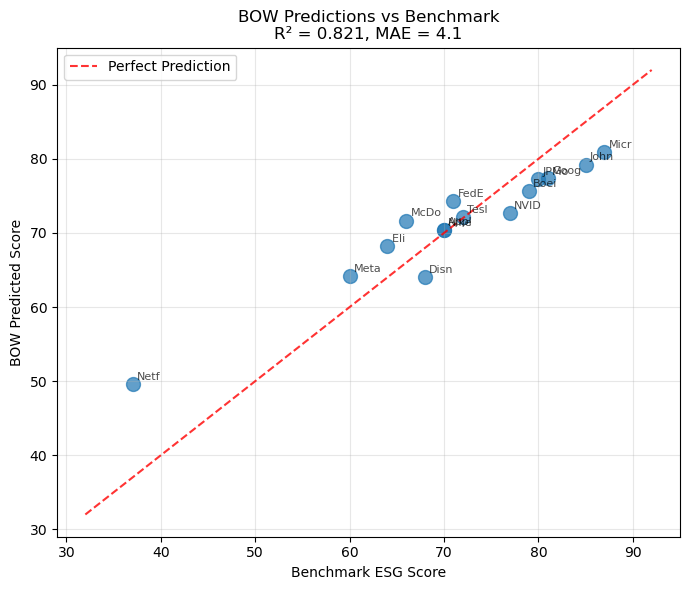

In [216]:
# 8. Visualization: Predicted vs Actual Scores Only

def plot_predicted_vs_actual():
    """
    Plot Predicted vs Actual ESG Scores for BOW model
    """
    plt.figure(figsize=(7, 6))
    plt.scatter(eval_df['Benchmark_Score'], eval_df['BOW_Predicted'], alpha=0.7, s=100)

    # Perfect prediction line
    min_score = min(eval_df['Benchmark_Score'].min(), eval_df['BOW_Predicted'].min()) - 5
    max_score = max(eval_df['Benchmark_Score'].max(), eval_df['BOW_Predicted'].max()) + 5
    plt.plot([min_score, max_score], [min_score, max_score], 'r--', alpha=0.8, label='Perfect Prediction')

    plt.xlabel('Benchmark ESG Score')
    plt.ylabel('BOW Predicted Score')
    plt.title(f'BOW Predictions vs Benchmark\nR² = {r2_overall:.3f}, MAE = {mae_overall:.1f}')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Add company labels
    for _, row in eval_df.iterrows():
        plt.annotate(row['Company'][:4], (row['Benchmark_Score'], row['BOW_Predicted']),
                     xytext=(3, 3), textcoords='offset points', fontsize=8, alpha=0.7)

    plt.tight_layout()
    plt.show()

plot_predicted_vs_actual()
